**1.Target:**

 Adding image augumentation in the architecture jsut to increase the variation in the image so that training become difficult and hencce test accuracy will improve

**2.Results**:

1.   Parameters :7904
2.   Best Train Accuracy: 94.06
3.   Best Test Accuracy: 99.41


**3.Analysis:**

Final Model has 7904 paramter since train accuracy is less than test accuracy hence there is a chances of improvement and here weacheived the accuracy of model greater than 99.4 with paramter less than 8000 and less than 15 epochs

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dropout_value = .05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels= 32,kernel_size= (3, 3), padding=0, bias=False),    #output_image = 26, RF=3
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Dropout2d(dropout_value)
            )

        #Transition BLOCK 1
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels= 8,kernel_size= (1, 1), padding=0, bias=False),    #output_image = 26, RF=3
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8),
            nn.Dropout2d(dropout_value)
        )

        #CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8,out_channels= 10,kernel_size= (3, 3), padding=0, bias=False),    #output_image = 24, RF=5
            nn.ReLU(),
            nn.BatchNorm2d(num_features=10),
            nn.Dropout2d(dropout_value)
        )
        self.pool1 = nn.MaxPool2d(2, 2)    #output_image = 12, RF=6


        #CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels=16 ,kernel_size= (3, 3), padding=1, bias=False),    #output_image = 10, RF=10
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout2d(dropout_value)
        )

        #TRANSITION BLOCK 2
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels= 10,kernel_size= (1, 1), padding=0, bias=False),    #output_image = 10, RF=10
            nn.ReLU(),
            nn.BatchNorm2d(num_features=10),
            nn.Dropout2d(dropout_value)
        )

        #CONVOLUTION BLOCK 3
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels= 10,kernel_size= (3, 3), padding=0, bias=False),    #output_image = 8, RF=14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=10),
            nn.Dropout2d(dropout_value)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels= 16,kernel_size= (3, 3), padding=0, bias=False),    #output_image = 8, RF=20
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout2d(dropout_value)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels= 16,kernel_size= (3, 3), padding=0, bias=False),    #output_image = 6, RF=24
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout2d(dropout_value)
        )


        #GAP Layer
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6),

        )

        # FC layer
        self.trans3 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels= 10,kernel_size= (1, 1), padding=0, bias=False),    #output_image = 6, RF=28
            #nn.ReLU()  NEVER!!!!
            #nn.BatchNorm2d(num_features=10)     NEVER!!!!
            #nn.Dropout2d(dropout_value)    NEVER!!!!
        )


    def forward(self, x):
      x = self.convblock1(x)
      x = self.trans1(x)
      x = self.convblock2(x)
      x = self.pool1(x)
      x = self.convblock3(x)
      x = self.trans2(x)
      x = self.convblock4(x)
      x = self.convblock5(x)
      x = self.convblock6(x)
      x = self.gap(x)
      x =self.trans3(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)


In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
       BatchNorm2d-3           [-1, 32, 26, 26]              64
         Dropout2d-4           [-1, 32, 26, 26]               0
            Conv2d-5            [-1, 8, 26, 26]             256
              ReLU-6            [-1, 8, 26, 26]               0
       BatchNorm2d-7            [-1, 8, 26, 26]              16
         Dropout2d-8            [-1, 8, 26, 26]               0
            Conv2d-9           [-1, 10, 24, 24]             720
             ReLU-10           [-1, 10, 24, 24]               0
      BatchNorm2d-11           [-1, 10, 24, 24]              20
        Dropout2d-12           [-1, 10, 24, 24]               0

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.016, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.12164772301912308 Batch_id=468 Accuracy=85.69: 100%|██████████| 469/469 [00:27<00:00, 16.99it/s]



Test set: Average loss: 0.0535, Accuracy: 9849/10000 (98.49%)

EPOCH: 1


Loss=0.10364639759063721 Batch_id=468 Accuracy=96.57: 100%|██████████| 469/469 [00:22<00:00, 20.42it/s]



Test set: Average loss: 0.0388, Accuracy: 9875/10000 (98.75%)

EPOCH: 2


Loss=0.05502824857831001 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]



Test set: Average loss: 0.0278, Accuracy: 9911/10000 (99.11%)

EPOCH: 3


Loss=0.06946039944887161 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:22<00:00, 21.22it/s]



Test set: Average loss: 0.0255, Accuracy: 9918/10000 (99.18%)

EPOCH: 4


Loss=0.08355110883712769 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:24<00:00, 19.37it/s]



Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 5


Loss=0.08696865290403366 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]



Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.031690116971731186 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]



Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.058182939887046814 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]



Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 8


Loss=0.040724992752075195 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]



Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.03364765644073486 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]



Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.03446009382605553 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]



Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.02190926857292652 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:23<00:00, 20.08it/s]



Test set: Average loss: 0.0184, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.010479454882442951 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:23<00:00, 19.87it/s]



Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.05077613890171051 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:24<00:00, 19.12it/s]



Test set: Average loss: 0.0177, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.0323883481323719 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]



Test set: Average loss: 0.0191, Accuracy: 9935/10000 (99.35%)



Text(0.5, 1.0, 'Test Accuracy')

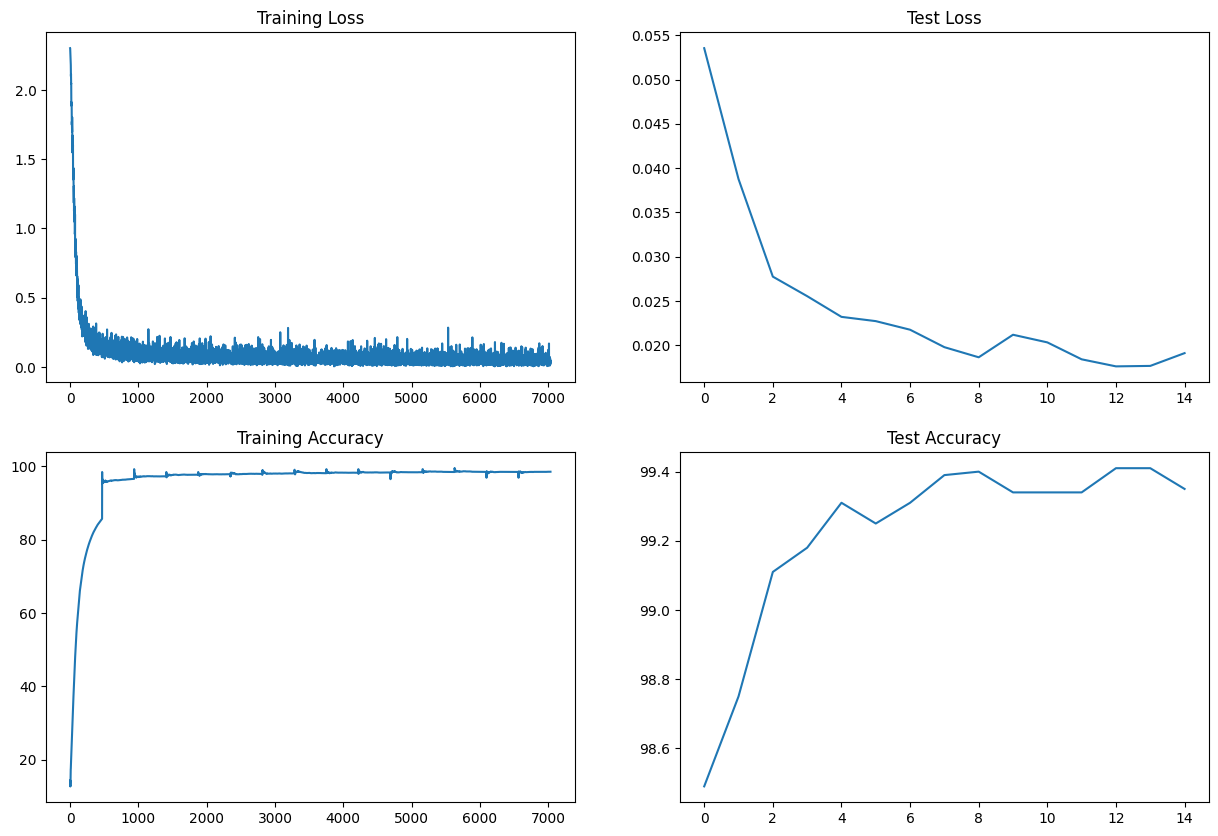

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")